# Neural Cellular Automata Tutorial

## Introduction


Play around with the animation at this [link](https://distill.pub/2020/growing-ca/), on the right you can change some parameters.  

In this notebook you will learn how the Cellular Automata model behind that animation works and how it is trained.  
Finally, you will train a Neural Cellular Automata that represents any image!

## Recap on Cellular Automata



A rigorus mathematical definition of a CA can be found [here](https://plato.stanford.edu/entries/cellular-automata/#SomeBasiNotiResu), however, a more intuitive definition is:

A Cellular Automata (CA) consists of a grid of cells that is iteratively updated using the same transition rule $f$ at each step, the only requirement is that the next state of each cell depends only on its previous state $x_t$ and the state of its neighbors $N(x_t)$.  

$$x_{t+1}= f(x_t , N(x_t))$$

Even though it might seem a limitation to always apply the same rule $f$ on a local neighborhood, this simple system has been proven to be Turing complete, which means it can approximate any function [1], even itself https://www.youtube.com/watch?v=xP5-iIeKXE8.

To make the definition more intuitive, consider the hat rule:  

Hat rule: a student will wear the hat in the next class if one or the other, but not both, of the two classmates sitting immediately on her left and on her right has the hat in the current class (if nobody wears a hat, a hat is out of fashion; but if both neighbors wear it, a hat is now too popular to be trendy).

Initial class: during the first class in the morning, only one student in the middle shows up with a hat.

We can summarize the hat rule in 4 points:
1. The cells lie in a 1-dimensional lattice.

2. The states $x_t$ are either 0 or 1 (1 = hat on, 0 = hat off)

3. Each cell’s neighborhood is composed by the two nearest cells. If $c_i$ is cell number $i$, then $N(c_i)=\{c_{i−1}, c_{i+1}\}$

4. The transition rule $f$ is simple: at each time step $t$, a cell state is $1$ if exactly one of the neighboring cells was $1$ at $t−1$, $0$ otherwise.

We can readily implement the hat rule in python

In [1]:
import pylab as pl
import numpy as np

import torch
import torch.nn.functional as F

class HatRule:
    """The classroom is represented as a list of int where 1 is a student with a hat and 0 is a student without a hat"""
    def __init__(self, size: int = 50):
        self.size = size
        self.classroom = self.get_initial_classroom(size)

    @staticmethod
    def get_initial_classroom(size: int) -> torch.Tensor:
        # In the first class of the morning only the student in the middle has a hat
        classroom = torch.zeros(size, dtype=torch.int8)
        classroom[size // 2] = 1
        return classroom

    def set_classroom(self, classroom: torch.Tensor):
        self.classroom = classroom.clone()
    
    def get_classroom(self) -> torch.Tensor:
        return self.classroom.clone()

    def step(self) -> torch.Tensor:
        ## TODO: Write the update rule of the hat rule, to avoid boundary problems avoid updating the cells at the boundary
        next_classroom = self.classroom.clone()
        for i in range(1, self.size - 1):
            next_classroom[i] = (self.classroom[i - 1] + self.classroom[i + 1]) % 2
        return next_classroom

    def evolve(self, n_steps: int) -> torch.Tensor:
        """Evolve the classroom for n_steps steps"""
        for _ in range(n_steps):
            self.classroom = self.step()
        return self.classroom.clone()

    def plot_evolution(self, n_steps: int = 100):
        classrooms = torch.empty((n_steps+1, self.size), dtype=torch.int8)
        classrooms[0] = self.get_classroom()
        for i in range(1, n_steps+1):
            classrooms[i] = self.evolve(1)
        pl.matshow(classrooms.detach().numpy())

If you implemented correctly the `step` method, below you should see a fractal made of triangles, which is in fact [Sierpiński triangle](https://en.wikipedia.org/wiki/Sierpi%C5%84ski_triangle).

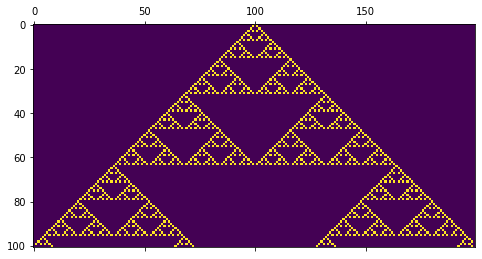

In [2]:
rule = HatRule(size=200)
rule.plot_evolution(n_steps=100)

In the above figure the x axis represents the cell number and the y axis the number of iterations, the figure shows a clear example of emergence:
> The evolutionary pattern displayed contrasts with the simplicity of the underlying law (the “Hat rule”) [...]. The global, emergent behavior of the system supervenes upon its local, simple features.  
> -- <cite>Stanford encyclopedia of Philosophy</cite>

We encourage the reader who is interested in Cellular Automata to take a look at the [Stanford encyclopedia of Philosophy article](https://plato.stanford.edu/entries/cellular-automata) about it, where they discuss emergent behaviours, Turing completeness and the edge of chaos hypothesis among other things.  

Here we will focus on Neural Cellular Automata.

## CA as Convolutional Neural Networks

As we said a CA rule is described by the equation

$$x_{t+1} = f(x_t , N(x_t))$$

And since neural networks can act as universal function approximators, a sufficiently complex NN architecture can be used to fully approximate any transition rule $f$.

Now consider a 1D grid where the states $x_t$ are real values and follow the transition rule:

$$x^{t+1}_i = 0.5 \cdot (x^t_{i-1} + x^t_{i+1})$$

We can apply this rule to each cell individually, or we can apply it to every cell at once using a convolution with filter $[0.5, 0, 0.5]$.

From this simple example it should be clear that the analogy between Cellular Automata (CA) and Convolutional Neural Networks (CNN) arises from:

* **Locality of the dynamics** both CA and CNN consider a local neighbor.
* **Simultaneous temporal updating** of all cells/pixels.  

In other words, both in CNN and CA the same $f$ acts only on a **local neighborhood** and is **applied simultaneously** to all the pixels/cells.

The neighborhood operator $N$ can be implemented with convolutions as well, we only need to choose kernels large enough to cover all neighbors [3]. In the previous example we implemented $N$ using a convolution with filter $[0.5, 0, 0.5]$ and we didn't had to perform any other operations on the output.

One concept that might be tricky to grasp is how a CNN can approximate any function $f$. However, note that any MLP architecture can always be implemented by considering the features as the channels of an image and applying 1x1 convolutions on it, and since MLPs have been shown to be universal feature approximators, CNNs are as well. To see how an MLP can be implemented using only 1x1 convolutions see [this notebook](https://colab.research.google.com/drive/1eeSVGp-sGB0UF0g2hihPGYHDccosyusG?usp=sharing)

To make the CA/CNN parallelism clearer we implement the hat rule using convolutions.

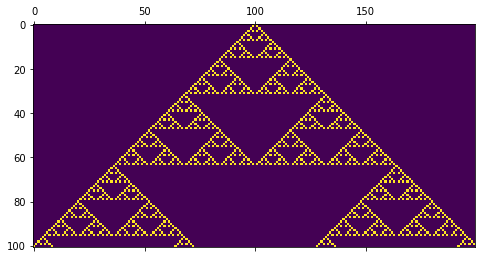

In [3]:
def conv1d(input, weight):
  """Helper function to compute the 1d convolution of input with weight.
  The documentation of F.conv1d can be found at https://pytorch.org/docs/stable/generated/torch.nn.functional.conv1d.html"""
  return F.conv1d(input.view(1, 1, -1), weight.view(1, 1, -1), padding="same").ravel()

class HatRuleCNN(HatRule):
    def step(self) -> torch.Tensor:
        ## TODO: Write the hat rule implementing the perception vector using conv1d
        ## Note: In the compute phase you can use any operations
        weight = torch.tensor([1, 0, 1], dtype=torch.int8)
        perception = conv1d(self.classroom, weight)
        return perception % 2

rule = HatRuleCNN(200)
rule.plot_evolution(100)

# Neural Cellular Automata

Before diving into Neural Cellular Automata (NCA), we encourage to read the description of how the NCA model works [here](https://distill.pub/2020/growing-ca/#model), where the authors explain in a clear and detailed way the whole NCA model and the biological ideas that went into designing it.

Here we provide a summary of the model.

1. The cells lie in a 2-dimensional lattice.

2. The state $x_t$ is a vector of 16 real values. The first four components represent the RGBA channels of the pixel, the alpha channel tells whether a cell is alive or dead, and the remaining 12 hidden channels are used to pass information.

3. Each cell’s neighborhood is composed by eight neighboring cells (Moore neighborhood).

4. The transition rule $f$ is represented by a neural network and can be learned.

### Simplified transition rule
To make things easier we consider a simplified version of the transition rule described in the paper.  

**Perception.** Instead of using the sobel x,y and identity filters, we learn 128 3x3x16 convolutional filters, this eases the implementation and at the same time speeds up the training.  
**Update rule.** We leave the update rule as is: it consists of a series of 1x1 convolutions and ReLU non linearities with a skip connection.  
**Stochastic cell update.** We remove it.  
**Living cell masking.** We remove it.  

Mathematically we can write the simplified transition rule as follows:

$$x_{t+1} = x_t + f(x_t, N(x_t))$$

The picture below shows the simplified rule.

In [ ]:
from IPython.display import Image
Image('NCA_model.png', width=120) # You may need to increase/decrease width if the image is too small/large

## Implementation

### Notebook Utilities

In [35]:
from torchvision.transforms.functional import InterpolationMode
!pip install einops moviepy

from torchvision.io import read_image, ImageReadMode
import torchvision.transforms as T
from einops import rearrange
from random import randint

from IPython.display import clear_output

import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter

torch.backends.cudnn.benchmark = True


def imread(filename: str, mode=ImageReadMode.RGB_ALPHA):
  image = read_image(filename, mode=mode).float()
  return image / 255


def to_rgb(image):
  image = torch.clip(image, 0, 1)
  return image[3] * image[:3] + (1-image[3])


def resize(image: torch.Tensor, width=40, height=40):
  transforms = T.Compose([
                          T.ToPILImage(),
                          T.Resize((width, height), InterpolationMode.NEAREST),
                          T.ToTensor()
  ])
  return transforms(image[:4])


def rescale(image: torch.Tensor, scale: int = 4):
  return T.Resize((image.shape[-2]*scale, image.shape[-1]*scale), T.InterpolationMode.NEAREST)(image)


def make_collage(images: torch.Tensor):
  return rearrange(images, 'b c h w -> c h (b w)')


def imshow(image: torch.Tensor):
  if len(image.size()) == 4:
    image = make_collage(image[:, :4])
  pl.imshow(image[:4].detach().cpu().permute(1,2,0))
  pl.axis('off')
  pl.show()


class VideoWriter:
  # class to make NCA evolution videos
  def __init__(self, filename='_autoplay.mp4', fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()
    if self.params['filename'] == '_autoplay.mp4':
      self.show()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))

  clear_output()

### NCA model

In [607]:
from torch import nn

class NCA(nn.Module):
  def __init__(self, n_channels=16):
    super().__init__()
    self.n_channels = n_channels
    ## TODO: Write the 2D convolutional layers in the forward pass
    ## If you use convolutions with a kernel bigger than 1x1 use padding to
    ## keep the dimensions unchanged and set padding_mode="circular" to
    ## avoid boundary problems
    self.layers = nn.Sequential(
          nn.Conv2d(n_channels, 256, kernel_size=3, padding=1, padding_mode="circular"),
          nn.ReLU(),
          nn.Conv2d(256, n_channels, kernel_size=1)
          )
    
    for name, param in self.named_parameters():
      if "2" in name:
          param.data.zero_()

  def wrap_edges(self, x: torch.Tensor) -> torch.Tensor:
    return F.pad(x, pad=(1, 1, 1, 1), mode='circular')

  def get_live_mask(self, x: torch.Tensor) -> torch.Tensor:
    return F.max_pool2d(self.wrap_edges(x), kernel_size=3, stride=1) > 0.1

  def stochastic_update(self, x: torch.Tensor) -> torch.Tensor:
    return (torch.rand(x.size(), device=x.device) < 0.5).float()

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return x + self.layers(x)# * self.stochastic_update(x)

  def evolve(self, x, n_steps: int) -> torch.Tensor:
    for _ in range(n_steps):
        x = self.forward(x)
    return x

### Training parameters

In [608]:
torch.cuda.cudnn_benchmark = True

In [624]:
target_size = [62, 44]
padding = 4
n_channels = 24
padded_target_size = [size + 2*padding for size in target_size]
evolution_steps = [60, 80]
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

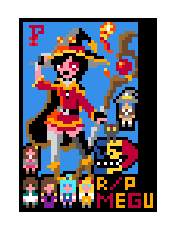

In [625]:
target = imread("megu.png") # You have to upload an image here
target = resize(target, *target_size)
target = T.Pad(padding)(target)
imshow(target)

### Train loop

In [626]:
def get_equispaced_points(start, finish, n_points):
  spacing = (finish - start) / n_points / 2
  return np.linspace(start, finish, n_points, endpoint=False) + spacing

In [627]:
def make_seed(n_images, n_channels, image_height, image_width, device="cpu"):
  seed = torch.zeros((n_images, n_channels, image_height, image_width), device=device)
  heights = get_equispaced_points(0, image_height, 1).astype(int)
  widths = get_equispaced_points(0, image_width, 1).astype(int)

  n = 3
  for h in heights:
    for w in widths:
      seed[:, n, h, w] = 1
      seed[:, 3, h, w] = 1
      n += 1

  return seed

def train_step(seed, target, optimizer, evolution_steps, criterion):
  optimizer.zero_grad()
  for i in range(evolution_steps[0]):
    seed = nca(seed)

  losses = torch.zeros((evolution_steps[1] - evolution_steps[0],), device=device)
  for i in range(evolution_steps[1] - evolution_steps[0]):
    seed = nca(seed)
    losses[i] = criterion(seed[:, :4], target)

  loss = losses.mean()
  loss.backward()
  
  # Gradient normalization avoids exploding gradient issues
  [param.grad.div_(torch.norm(param.grad) + 1e-8) for param in nca.parameters()]
  optimizer.step()

  return loss.item(), seed

In [628]:
# Initialize NCA
nca = NCA(n_channels).to(device)

In [629]:
pool_size = 512
batch_size = 12
pool = make_seed(pool_size, n_channels, *padded_target_size, "cpu")
all_indices = np.arange(pool_size, dtype=int)

In [606]:
# torch.save({"nca": nca, "seed": make_seed(1, n_channels, *padded_target_size, "cpu")}, "megu_2.pt")

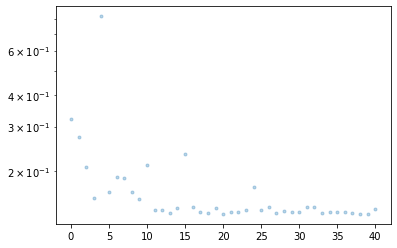

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


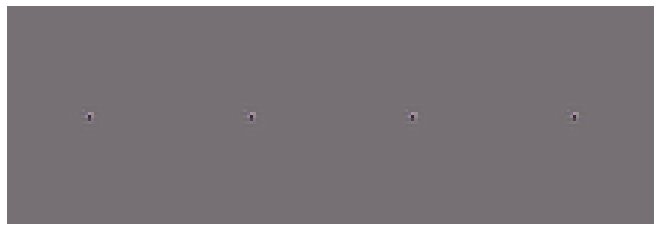

step: 40 loss: 0.14139235019683838


In [ ]:
#@title {vertical-output: true}
optimizer = torch.optim.Adam(nca.parameters(), lr=1e-3)
target = target.to(device)
criterion = nn.MSELoss()

nca.train()
losses = []
for i in range(1000):
  sampled_indices = np.random.choice(all_indices, batch_size, replace=False)
  images = pool[sampled_indices].to(device)
  images[:4] = make_seed(4, n_channels, *padded_target_size, device)
  loss, output = train_step(images, target, optimizer, evolution_steps, criterion)
  pool[sampled_indices] = output.detach().cpu()
  losses.append(loss)

  if i%10 == 0:
    clear_output(wait=True)
    pl.plot(losses, '.', alpha=0.3)
    pl.yscale("log")
    pl.show()
    pl.figure(figsize = (16,4))
    imshow(output[:4])
    print(f"step: {i} loss: {loss}", flush=True)

### Evolution Video

In [605]:
seed = make_seed(1, n_channels, *padded_target_size, device)

with torch.no_grad():
  with VideoWriter(fps=10) as vid:
    x = seed.clone()
    for i in range(evolution_steps[1] * 10):
      frame = rescale(to_rgb(x[0]), 8).permute(1,2,0)
      vid.add(frame.cpu())
      x = nca(x)

## References

[1] Berto, Francesco and Jacopo Tagliabue, "Cellular Automata", The Stanford Encyclopedia of Philosophy (Spring 2022 Edition), Edward N. Zalta (ed.), forthcoming URL = <https://plato.stanford.edu/archives/spr2022/entries/cellular-automata/>. 

[2] Mordvintsev, et al., "Growing Neural Cellular Automata", Distill, 2020. URL = <https://distill.pub/2020/growing-ca/>

[3] William Gilpin, "Cellular automata as convolutional neural networks", arXiv, 2018. URL = <https://arxiv.org/abs/1809.02942>